# IT492 Recommendation Systems


## Loading Dataset from Kaggle


In [1]:
!mkdir key data

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/key"

In [3]:
!chmod 600 /content/key/kaggle.json

In [4]:
!kaggle datasets download -d shuyangli94/food-com-recipes-and-user-interactions

 98% 261M/267M [00:02<00:00, 99.0MB/s]
100% 267M/267M [00:03<00:00, 93.1MB/s]


In [5]:
!unzip "/content/food-com-recipes-and-user-interactions.zip" -d data && rm "/content/food-com-recipes-and-user-interactions.zip"

Archive:  /content/food-com-recipes-and-user-interactions.zip
  inflating: data/PP_recipes.csv     
  inflating: data/PP_users.csv       
  inflating: data/RAW_interactions.csv  
  inflating: data/RAW_recipes.csv    
  inflating: data/ingr_map.pkl       
  inflating: data/interactions_test.csv  
  inflating: data/interactions_train.csv  
  inflating: data/interactions_validation.csv  


In [6]:
!rm key -R

## 1. Exploratory Data Analysis and 2. Feature Extraction

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')

In [9]:
raw_interactions = pd.read_csv("/content/data/RAW_interactions.csv")
raw_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [10]:
raw_recipes = pd.read_csv("/content/data/RAW_recipes.csv")
raw_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [11]:
# print(f'Raw Interactions Shape: {raw_interactions.shape}')
print(f'Raw Recipes Shape: {raw_recipes.shape}')

Raw Recipes Shape: (231637, 12)


In [15]:
# Sampling because the datasets are too large
# Will comment this cell out after further analysis

# raw_interactions = raw_interactions.sample(n=10000, axis=0, random_state=1)
raw_recipes = raw_recipes.sample(n=10000, axis=0, random_state=1, ignore_index=True)

In [16]:
# print(f'Raw Interactions Sample Shape: {raw_interactions.shape}')
print(f'Raw Recipes Sample Shape: {raw_recipes.shape}')

Raw Recipes Sample Shape: (10000, 12)


In [17]:
data = raw_recipes.copy()
data.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,baked red snapper,60009,30,45654,2003-04-17,"['30-minutes-or-less', 'time-to-make', 'course...","[342.8, 11.0, 10.0, 5.0, 120.0, 6.0, 1.0]",6,"['preheat oven to 375 degrees', 'brush pan wit...",yummy fish entree that i got from a lady at my...,"['olive oil', 'red snapper fillets', 'onion', ...",5
1,guacamol eh la bas,165808,10,47892,2006-04-26,"['15-minutes-or-less', 'time-to-make', 'course...","[497.8, 65.0, 22.0, 5.0, 14.0, 39.0, 10.0]",6,"['to avoid turning brown , using the tines of ...","lousiana is after all, only a hop, skip and a ...","['avocados', 'paprika', 'lemon, juice of', 'so...",16
2,border paella,369837,55,444132,2009-05-05,"['60-minutes-or-less', 'time-to-make', 'course...","[412.4, 17.0, 31.0, 50.0, 16.0, 8.0, 23.0]",10,"['in a large , deep cast iron skillet , heat o...","a lovely rice dish with sweet peppers, green b...","['olive oil', 'onion', 'garlic cloves', 'red c...",19
3,chocolate almond fudge cake,17182,60,5060,2002-01-14,"['60-minutes-or-less', 'time-to-make', 'course...","[399.8, 32.0, 109.0, 16.0, 13.0, 54.0, 16.0]",11,['measure all cake ingredients into large mixe...,"this made a great special occasion cake, (birt...","['all-purpose flour', 'sugar', 'cocoa', 'bakin...",14
4,dijon chicken,227649,30,420166,2007-05-12,"['30-minutes-or-less', 'time-to-make', 'course...","[248.4, 26.0, 0.0, 5.0, 42.0, 24.0, 0.0]",13,"['to make this a oamc recipe , place chicken i...","this is a simple, economical dish, which can b...","['boneless chicken', 'dijon mustard', 'lemon j...",5


In [18]:
nutrients = ['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']
data[nutrients] = data.nutrition.str.split(",",expand=True)
data['calories'] = data['calories'].apply(lambda x: x.replace("[" ,""))
data['carbohydrates'] = data['carbohydrates'].apply(lambda x: x.replace("]" ,""))
data[nutrients] =  data[nutrients].astype(float)
data.drop(['submitted', 'steps', 'nutrition', 'contributor_id'], axis=1, inplace=True)

In [19]:
data.head()

,name,id,minutes,tags,n_steps,description,ingredients,n_ingredients,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates
0,baked red snapper,60009,30,"['30-minutes-or-less', 'time-to-make', 'course...",6,yummy fish entree that i got from a lady at my...,"['olive oil', 'red snapper fillets', 'onion', ...",5,342.8,11.0,10.0,5.0,120.0,6.0,1.0
1,guacamol eh la bas,165808,10,"['15-minutes-or-less', 'time-to-make', 'course...",6,"lousiana is after all, only a hop, skip and a ...","['avocados', 'paprika', 'lemon, juice of', 'so...",16,497.8,65.0,22.0,5.0,14.0,39.0,10.0
2,border paella,369837,55,"['60-minutes-or-less', 'time-to-make', 'course...",10,"a lovely rice dish with sweet peppers, green b...","['olive oil', 'onion', 'garlic cloves', 'red c...",19,412.4,17.0,31.0,50.0,16.0,8.0,23.0
3,chocolate almond fudge cake,17182,60,"['60-minutes-or-less', 'time-to-make', 'course...",11,"this made a great special occasion cake, (birt...","['all-purpose flour', 'sugar', 'cocoa', 'bakin...",14,399.8,32.0,109.0,16.0,13.0,54.0,16.0
4,dijon chicken,227649,30,"['30-minutes-or-less', 'time-to-make', 'course...",13,"this is a simple, economical dish, which can b...","['boneless chicken', 'dijon mustard', 'lemon j...",5,248.4,26.0,0.0,5.0,42.0,24.0,0.0


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           10000 non-null  object 
 1   id             10000 non-null  int64  
 2   minutes        10000 non-null  int64  
 3   tags           10000 non-null  object 
 4   n_steps        10000 non-null  int64  
 5   description    9794 non-null   object 
 6   ingredients    10000 non-null  object 
 7   n_ingredients  10000 non-null  int64  
 8   calories       10000 non-null  float64
 9   total fat      10000 non-null  float64
 10  sugar          10000 non-null  float64
 11  sodium         10000 non-null  float64
 12  protein        10000 non-null  float64
 13  saturated fat  10000 non-null  float64
 14  carbohydrates  10000 non-null  float64
dtypes: float64(7), int64(4), object(4)
memory usage: 1.1+ MB


In [21]:
data.describe()

,id,minutes,n_steps,n_ingredients,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,220271.858000,148.442700,9.741100,9.020300,473.231560,36.447900,81.698800,28.712900,34.917200,46.01370,15.234100
std,139827.237101,2113.902927,5.812267,3.732544,749.510293,73.787774,257.541237,75.093097,64.509279,94.19707,30.966717
min,49.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,100598.750000,20.000000,6.000000,6.000000,175.200000,8.000000,9.000000,5.000000,7.000000,7.00000,4.000000
50%,205463.500000,40.000000,9.000000,9.000000,314.150000,20.500000,25.000000,15.000000,18.000000,23.00000,9.000000
75%,328315.750000,65.000000,12.000000,11.000000,516.200000,41.000000,68.000000,33.000000,50.000000,52.00000,16.000000
max,536568.000000,146880.000000,60.000000,38.000000,22371.200000,3464.000000,10365.000000,4755.000000,3268.000000,2477.00000,945.000000


<Axes: xlabel='n_steps', ylabel='Density'>

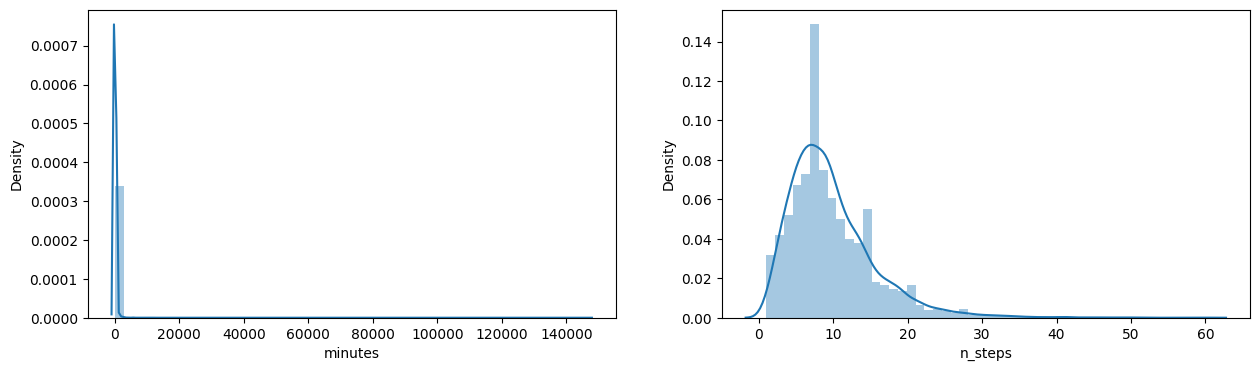

In [22]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.distplot(data["minutes"],ax=ax[0])
sns.distplot(data["n_steps"],ax=ax[1])

<Axes: ylabel='n_steps'>

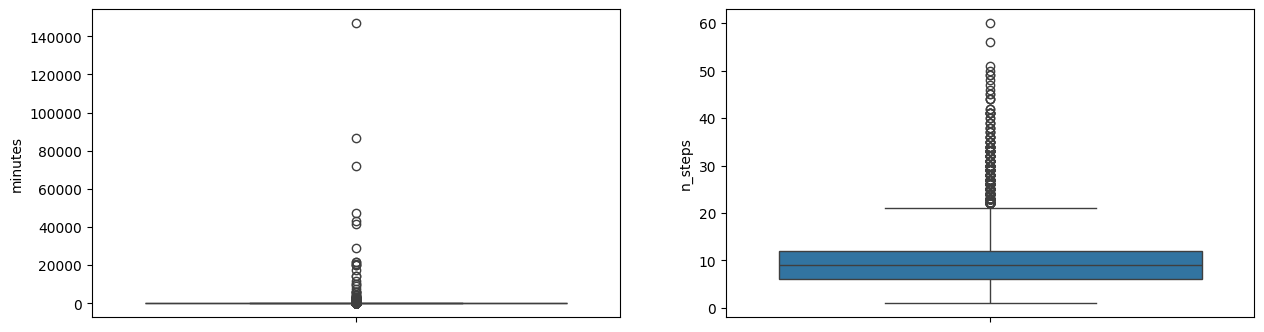

In [23]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.boxplot(data=data["minutes"],ax=ax[0])
sns.boxplot(data=data["n_steps"],ax=ax[1])

Here, we can see the skewness of the n_steps and minutes columns of the dataset. Also, there is a hugh number of outliers in this set.

In [24]:
q1 = np.percentile(data["n_steps"],25)
q3 = np.percentile(data["n_steps"],75)
IQR = q3- q1
upper = q3 + 1.5*IQR
lower = q1 - 1.5*IQR

data = data.drop((data[data["n_steps"]>=upper].index | data[data["n_steps"]<=lower].index),axis=0).reset_index()

In [25]:
q1 = np.percentile(data["minutes"],25)
q3 = np.percentile(data["minutes"],75)
IQR = q3- q1
upper = q3 + 1.5*IQR
lower = q1 - 1.5*IQR

data = data.drop((data[data["minutes"]>=upper].index | data[data["minutes"]<=lower].index),axis=0).reset_index()

After Removing Outliers

<Axes: xlabel='n_steps', ylabel='Density'>

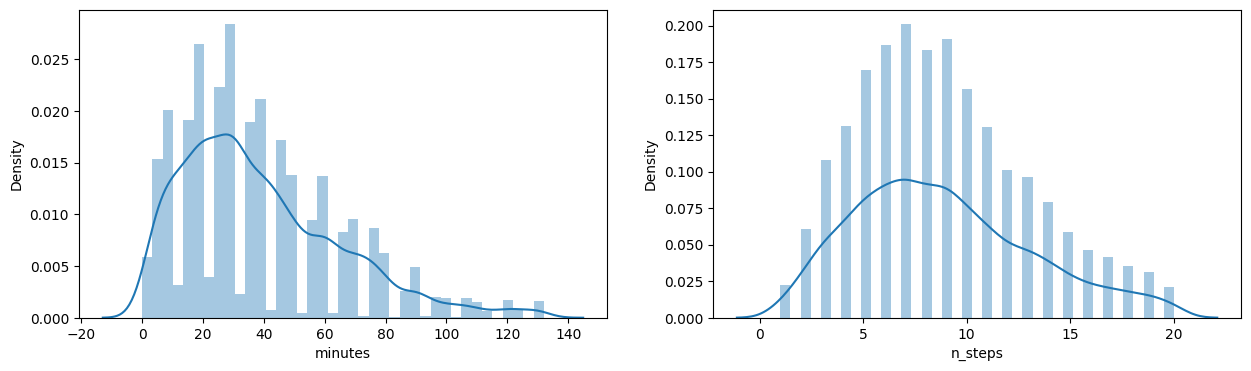

In [26]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.distplot(data["minutes"],ax=ax[0])
sns.distplot(data["n_steps"],ax=ax[1])

<Axes: >

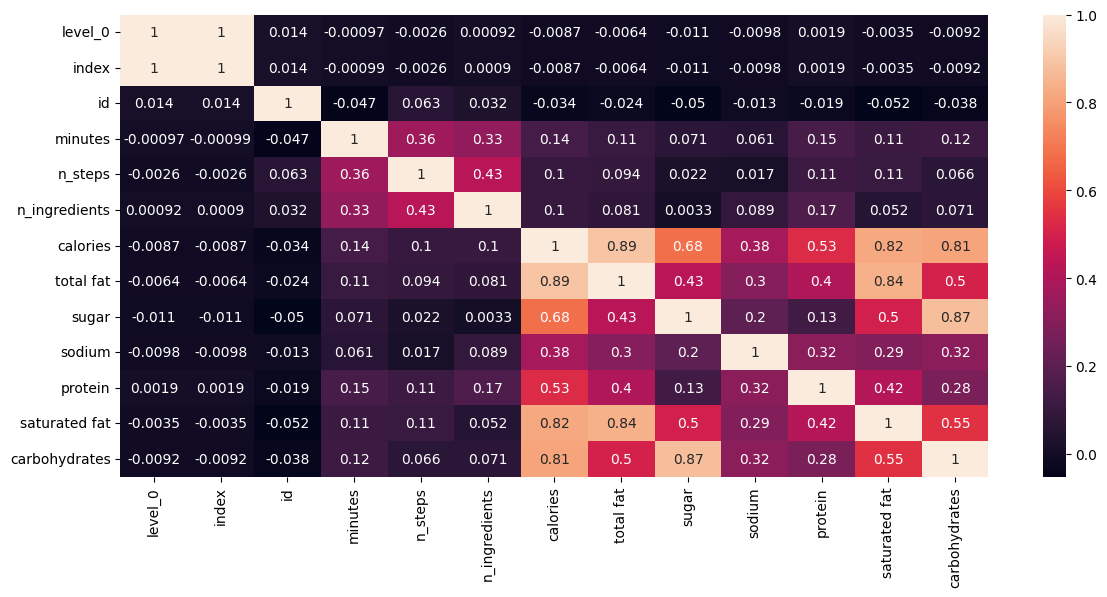

In [27]:
plt.figure(figsize=(14,6))
sns.heatmap(data.corr(),annot=True)

In [28]:
print(f'Data Shape after Removing Outliers: {data.shape}')

Data Shape after Removing Outliers: (8607, 17)


### Making binary features from tags for recipes

In [29]:
literal_eval(data.tags[0])

['30-minutes-or-less',
 'time-to-make',
 'course',
 'main-ingredient',
 'preparation',
 'healthy',
 '5-ingredients-or-less',
 'very-low-carbs',
 'main-dish',
 'seafood',
 'easy',
 'low-fat',
 'fish',
 'dietary',
 'low-sodium',
 'low-saturated-fat',
 'low-calorie',
 'high-protein',
 'low-carb',
 'high-in-something',
 'low-in-something']

In [30]:
data['tags'] = data['tags'].apply(lambda x: literal_eval(x))

In [31]:
data.tags[0]

['30-minutes-or-less',
 'time-to-make',
 'course',
 'main-ingredient',
 'preparation',
 'healthy',
 '5-ingredients-or-less',
 'very-low-carbs',
 'main-dish',
 'seafood',
 'easy',
 'low-fat',
 'fish',
 'dietary',
 'low-sodium',
 'low-saturated-fat',
 'low-calorie',
 'high-protein',
 'low-carb',
 'high-in-something',
 'low-in-something']

In [32]:
unique_tags = data['tags'].explode().unique()
features = pd.get_dummies(data['tags'].explode(), columns=unique_tags)
grouped_features = features.groupby(features.index).sum()
grouped_features

,,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,60-minutes-or-less,african,american,...,whitefish,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8602,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8603,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8604,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8605,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
data = pd.concat([data.drop(['tags'], axis=1), grouped_features], axis=1)
data.head()

,level_0,index,name,id,minutes,n_steps,description,ingredients,n_ingredients,calories,...,whitefish,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
0,0,0,baked red snapper,60009,30,6,yummy fish entree that i got from a lady at my...,"['olive oil', 'red snapper fillets', 'onion', ...",5,342.8,...,0,0,0,0,0,0,0,0,0,0
1,1,1,guacamol eh la bas,165808,10,6,"lousiana is after all, only a hop, skip and a ...","['avocados', 'paprika', 'lemon, juice of', 'so...",16,497.8,...,0,0,0,0,0,0,0,0,0,0
2,2,2,border paella,369837,55,10,"a lovely rice dish with sweet peppers, green b...","['olive oil', 'onion', 'garlic cloves', 'red c...",19,412.4,...,0,0,0,0,0,0,0,0,0,0
3,3,3,chocolate almond fudge cake,17182,60,11,"this made a great special occasion cake, (birt...","['all-purpose flour', 'sugar', 'cocoa', 'bakin...",14,399.8,...,0,0,0,0,0,0,1,0,0,0
4,4,4,dijon chicken,227649,30,13,"this is a simple, economical dish, which can b...","['boneless chicken', 'dijon mustard', 'lemon j...",5,248.4,...,0,0,0,0,0,0,0,0,0,0


## 3. Making a Content-based Recommendation System

### 1. Item-Item Similarity Based
Here, I have used the cosine similarities for each item-item pair in the dataframe and then recommend the top 10 similar recipes to the user.


Reference for this system: https://techvidvan.com/tutorials/movie-recommendation-system-python-machine-learning/

In [34]:
data['id'].value_counts()

60009     1
124203    1
94851     1
262832    1
472698    1
         ..
129821    1
21984     1
17333     1
198000    1
360267    1
Name: id, Length: 8607, dtype: int64

In [35]:
data.drop(columns=['index', 'level_0', 'description', 'ingredients'], inplace=True)
data.head()

,name,id,minutes,n_steps,n_ingredients,calories,total fat,sugar,sodium,protein,...,whitefish,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
0,baked red snapper,60009,30,6,5,342.8,11.0,10.0,5.0,120.0,...,0,0,0,0,0,0,0,0,0,0
1,guacamol eh la bas,165808,10,6,16,497.8,65.0,22.0,5.0,14.0,...,0,0,0,0,0,0,0,0,0,0
2,border paella,369837,55,10,19,412.4,17.0,31.0,50.0,16.0,...,0,0,0,0,0,0,0,0,0,0
3,chocolate almond fudge cake,17182,60,11,14,399.8,32.0,109.0,16.0,13.0,...,0,0,0,0,0,0,1,0,0,0
4,dijon chicken,227649,30,13,5,248.4,26.0,0.0,5.0,42.0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
data.shape

(8607, 485)

In [37]:
data.loc[0]

name                   baked red snapper
id                                 60009
minutes                               30
n_steps                                6
n_ingredients                          5
                             ...        
wings                                  0
winter                                 0
yams-sweet-potatoes                    0
yeast                                  0
zucchini                               0
Name: 0, Length: 485, dtype: object

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

items_name_map = pd.Series(data.index, index = data['name']).drop_duplicates()
cos_sims = cosine_similarity(data.loc[:, 'minutes':], data.loc[:, 'minutes':])

In [39]:
print(cos_sims.shape)

(8607, 8607)


In [40]:
def get_recommendations(name, cos_sims=cos_sims):
    idx = items_name_map[name]
    similarity_scores = list(enumerate(cos_sims[idx]))
    similarity_scores= sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores= similarity_scores[1:11]
    # (a, b) where a is id of movie, b is similarity_scores

    item_indices = [ind[0] for ind in similarity_scores]
    item = data["name"].iloc[item_indices]
    return item

In [41]:
items_name_map

name
baked red snapper                                0
guacamol eh la bas                               1
border paella                                    2
chocolate almond fudge cake                      3
dijon chicken                                    4
                                              ... 
mom s cinnamon cake with zucchini             8602
finnish tiikerikkakku  tiger cake             8603
bacon fried carrots                           8604
mexican chocolate coffee                      8605
matthew s healthy tex mex chicken and rice    8606
Length: 8607, dtype: int64

In [42]:
print("################ Content Based System #############")
item = 'potato gorgonzola gratin'
print(f"Recommendations for {item}")
print(get_recommendations(item, cos_sims))

################ Content Based System #############
Recommendations for potato gorgonzola gratin
4620                            broccoli stuffed tomatoes
1437                               japanese chicken wings
6939                  beer  bacon  and cheddar corn bread
820                                bacon and cabbage loaf
8532    baked butternut squash gratin   giada de laure...
3464                 crustless zucchini and tomato quiche
4268                    grandma s zucchini corn casserole
2535                  grilled stuffed mozzarella tomatoes
7477                 stuffed beef   pork red bell peppers
8285             tarte tatin aux courgettes  zucchini pie
Name: name, dtype: object


In [43]:
item = 'japanese chicken wings'
print(f"Recommendations for {item}")
print(get_recommendations(item, cos_sims))

Recommendations for japanese chicken wings
4620                            broccoli stuffed tomatoes
6912                                 overnight bagel bake
3573                             potato gorgonzola gratin
6656                                  creamed green beans
2535                  grilled stuffed mozzarella tomatoes
5772                            chicken gizzard paprikash
1232                                   shortbread skewers
8532    baked butternut squash gratin   giada de laure...
6022                              dixie cafe baked squash
8559                                   meatball casserole
Name: name, dtype: object


In [44]:
item = 'tomato stuffed roasted red peppers'
print(f"Recommendations for {item}")
print(get_recommendations(item, cos_sims))

Recommendations for tomato stuffed roasted red peppers
3783                            refreshing cucumber salad
3745                                  sugar coated pecans
37      feggous and tomato salad  moroccan chopped cuc...
3908        spinach  blood orange and macadamia nut salad
1171                                      ralph s carrots
4259      cauliflower in tomato sauce  kounoupithi yahini
5394                    pisto  spanish vegetable stir fry
431                                 30 minute pasta sauce
2253                              izzy s watercress salad
7769    grilled red pepper  sweet onion  and tomato salad
Name: name, dtype: object


This System gives top 10 similar items from the whole set based on the Cosine Similarity for the active Item or the item in the Query. It takes the title of one item and then searches for the top 10 recommendations which are relevant (similar) to it.

### 2. Query based Recommendation System
This System uses TF-IDF Vectorization by taking the vocabulary from [`name`, `description`, `steps` and `ingredients`] columns. So this is a baseline NLP Recommendation System which works on finding the most relevant recipe from the description provided by the user.

In [54]:
# df = pd.merge(raw_interactions, raw_recipes, left_on='recipe_id', right_on='id')
df = raw_recipes.copy()
df = df.drop(columns=['contributor_id', 'submitted'])
print(f'Dataset Shape: {df.shape}')
df.head()

Dataset Shape: (10000, 10)


,name,id,minutes,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,baked red snapper,60009,30,"['30-minutes-or-less', 'time-to-make', 'course...","[342.8, 11.0, 10.0, 5.0, 120.0, 6.0, 1.0]",6,"['preheat oven to 375 degrees', 'brush pan wit...",yummy fish entree that i got from a lady at my...,"['olive oil', 'red snapper fillets', 'onion', ...",5
1,guacamol eh la bas,165808,10,"['15-minutes-or-less', 'time-to-make', 'course...","[497.8, 65.0, 22.0, 5.0, 14.0, 39.0, 10.0]",6,"['to avoid turning brown , using the tines of ...","lousiana is after all, only a hop, skip and a ...","['avocados', 'paprika', 'lemon, juice of', 'so...",16
2,border paella,369837,55,"['60-minutes-or-less', 'time-to-make', 'course...","[412.4, 17.0, 31.0, 50.0, 16.0, 8.0, 23.0]",10,"['in a large , deep cast iron skillet , heat o...","a lovely rice dish with sweet peppers, green b...","['olive oil', 'onion', 'garlic cloves', 'red c...",19
3,chocolate almond fudge cake,17182,60,"['60-minutes-or-less', 'time-to-make', 'course...","[399.8, 32.0, 109.0, 16.0, 13.0, 54.0, 16.0]",11,['measure all cake ingredients into large mixe...,"this made a great special occasion cake, (birt...","['all-purpose flour', 'sugar', 'cocoa', 'bakin...",14
4,dijon chicken,227649,30,"['30-minutes-or-less', 'time-to-make', 'course...","[248.4, 26.0, 0.0, 5.0, 42.0, 24.0, 0.0]",13,"['to make this a oamc recipe , place chicken i...","this is a simple, economical dish, which can b...","['boneless chicken', 'dijon mustard', 'lemon j...",5


In [55]:
df.drop(columns=['minutes', 'tags', 'n_steps', 'nutrition', 'n_ingredients'], inplace=True)
df.head(3)

,name,id,steps,description,ingredients
0,baked red snapper,60009,"['preheat oven to 375 degrees', 'brush pan wit...",yummy fish entree that i got from a lady at my...,"['olive oil', 'red snapper fillets', 'onion', ..."
1,guacamol eh la bas,165808,"['to avoid turning brown , using the tines of ...","lousiana is after all, only a hop, skip and a ...","['avocados', 'paprika', 'lemon, juice of', 'so..."
2,border paella,369837,"['in a large , deep cast iron skillet , heat o...","a lovely rice dish with sweet peppers, green b...","['olive oil', 'onion', 'garlic cloves', 'red c..."


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         10000 non-null  object
 1   id           10000 non-null  int64 
 2   steps        10000 non-null  object
 3   description  9794 non-null   object
 4   ingredients  10000 non-null  object
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


In [57]:
df['steps'] = df['steps'].apply(literal_eval)
df['ingredients'] = df['ingredients'].apply(literal_eval)

In [58]:
df['steps'] = df['steps'].apply(lambda x: ' '.join(x))
df['ingredients'] = df['ingredients'].apply(lambda x: ' '.join(x))
df.head(3)

,name,id,steps,description,ingredients
0,baked red snapper,60009,preheat oven to 375 degrees brush pan with 1 t...,yummy fish entree that i got from a lady at my...,olive oil red snapper fillets onion plum tomat...
1,guacamol eh la bas,165808,"to avoid turning brown , using the tines of a ...","lousiana is after all, only a hop, skip and a ...","avocados paprika lemon, juice of sour cream to..."
2,border paella,369837,"in a large , deep cast iron skillet , heat oli...","a lovely rice dish with sweet peppers, green b...",olive oil onion garlic cloves red chili pepper...


In [59]:
df['corpus'] = df['name'] + ' ' + df['description'] + ' ' + df['ingredients'] + ' ' + df['steps']
df['corpus'].head()

0    baked red snapper yummy fish entree that i got...
1    guacamol eh la bas lousiana is after all, only...
2    border paella a lovely rice dish with sweet pe...
3    chocolate almond fudge cake this made a great ...
4    dijon chicken this is a simple, economical dis...
Name: corpus, dtype: object

In [60]:
df.head()

,name,id,steps,description,ingredients,corpus
0,baked red snapper,60009,preheat oven to 375 degrees brush pan with 1 t...,yummy fish entree that i got from a lady at my...,olive oil red snapper fillets onion plum tomat...,baked red snapper yummy fish entree that i got...
1,guacamol eh la bas,165808,"to avoid turning brown , using the tines of a ...","lousiana is after all, only a hop, skip and a ...","avocados paprika lemon, juice of sour cream to...","guacamol eh la bas lousiana is after all, only..."
2,border paella,369837,"in a large , deep cast iron skillet , heat oli...","a lovely rice dish with sweet peppers, green b...",olive oil onion garlic cloves red chili pepper...,border paella a lovely rice dish with sweet pe...
3,chocolate almond fudge cake,17182,measure all cake ingredients into large mixer ...,"this made a great special occasion cake, (birt...",all-purpose flour sugar cocoa baking soda baki...,chocolate almond fudge cake this made a great ...
4,dijon chicken,227649,"to make this a oamc recipe , place chicken int...","this is a simple, economical dish, which can b...",boneless chicken dijon mustard lemon juice bla...,"dijon chicken this is a simple, economical dis..."


In [64]:
df.isna().sum()

name             0
id               0
steps            0
description    206
ingredients      0
corpus         206
dtype: int64

In [67]:
df.dropna(axis=0, inplace=True)

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [68]:
vectorizer = TfidfVectorizer(stop_words='english')
tf_idf_matrix = vectorizer.fit_transform(df['corpus'])
tf_idf_matrix

<9794x19628 sparse matrix of type '<class 'numpy.float64'>'
	with 645091 stored elements in Compressed Sparse Row format>

In [85]:
def get_recommendations(query, vectorizer, tf_idf_matrix, df, num_suggestions=5):
  query_vector =  vectorizer.transform([query])

  sim_scores = cosine_similarity(query_vector, tf_idf_matrix).flatten()

  top_indices = sim_scores.argsort()[-num_suggestions:][::-1]
  recommendations = df.iloc[top_indices]
  return recommendations[['id', 'name']]

In [86]:
get_recommendations('baked red snapper', vectorizer, tf_idf_matrix, df, 10)

,id,name
0,60009,baked red snapper
1580,12890,red snapper a l orange
8777,222587,red snapper scampi
3289,93905,red snapper with garlic delight
5010,16905,crock pot snapper vera cruz
11,180682,blackened red snapper fillets
3507,63887,baked potato topping
3934,503239,baked beans with baked bacon
6414,365585,lemon dill broiled fish
7458,417949,yummy baked beans


In [90]:
get_recommendations('chilly sauce', vectorizer, tf_idf_matrix, df, 10)

,id,name
5105,141950,simple spiced cider
2104,353859,crispy tofu with sweet tangy glaze
2665,88472,cheddar and bacon potato soup
8804,260649,hearty potato and sausage chowder
7526,198751,non alcoholic hot buttered rum
6219,466307,moroccan chicken and couscous
201,76080,warm cheesy potato soup
8409,258833,vegan chocolate pudding cake crock pot
1440,57281,three delicious chinese sauces for chicken ...
763,30888,sweet and spicy bbq sauce


In [92]:
get_recommendations('aloo paratha', vectorizer, tf_idf_matrix, df, 10)

,id,name
800,16786,aloo paratha indian potato stuffed flatbreads
2180,352422,aloo gobi mattar
9874,190790,aloo keema potato and mince curry
6578,247540,aloo matar ki sabzi potato n peas curry
3869,350340,easy aloo dum
5669,384053,baked bean curry
9999,360267,matthew s healthy tex mex chicken and rice
3337,292973,cinnabon cinnamon rolls
3342,276903,v s crock pot bottom round roast
3341,143864,royal red robin burger


In [93]:
get_recommendations('samosa', vectorizer, tf_idf_matrix, df, 10)

,id,name
3990,457139,sambossa ethiopian appetizer
3282,114741,samosa filling with mashed potatoes
2682,117455,samosas
3365,214760,spicy three bean pasta salad
3364,119795,mediterranean cauliflower salad
3344,261093,steamed chorizo dim sims
3343,254782,dawn s amish friendship cake with starters
3342,276903,v s crock pot bottom round roast
3341,143864,royal red robin burger
3340,167597,fluffy fruit dessert


## 4. References

1. https://medium.com/@prateekgaurav/step-by-step-content-based-recommendation-system-823bbfd0541c

2. https://medium.com/web-mining-is688-spring-2021/article-recommendation-system-using-python-8b0fec6e6de8